# Modelado
Creacion e implementacion de modelos para predecir expecativa de ol de equipos.

## Preparacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.image as mpimg
import os

In [2]:
# Importo mis funciones personalizadas
import custom_functions as cf

## Obtengo los datos ya filtrados

In [3]:
directorio_filtered = './filtered_data'

ruta_posiciones_filtered = os.path.join(directorio_filtered, 'data_posiciones_filtered.csv')
data_posiciones_filtered = pd.read_csv(ruta_posiciones_filtered)

ruta_goles_filtered = os.path.join(directorio_filtered, 'data_goles_filtered.csv')
data_goles_filtered = pd.read_csv(ruta_goles_filtered)

In [4]:
data_posiciones_filtered.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados
41214,69895,102,108,261.611105,-22.479452,121.622431,7.684455e+01,84.033333,2,1
45596,75589,111,117,218.956606,123.050427,152.231087,1.361209e+01,114.333333,1,1
64252,96743,140,0,14.889823,-221.142721,201.148760,-4.094853e+01,137.850000,0,1
61765,93945,136,112,-427.225630,0.633275,69.045086,-8.424426e+01,92.316667,1,1
66240,98878,146,0,527.125302,-167.974638,251.283596,-9.047751e+01,69.266667,0,1
23185,47874,75,58,-44.409745,72.125416,77.019151,4.938856e-08,164.083333,1,1
57614,89298,130,2,-204.925726,143.149740,0.470026,-7.447311e-01,63.233333,2,1


In [5]:
data_goles_filtered.sample(7)

,id,match_id,player_id,player_name,equipo,tick
34,197,55,48,"marco!""",Blue,152.016667
208,414,140,2,tnt,Blue,154.650000
170,370,124,117,Tuc,Blue,106.566667
151,350,116,112,belu,Blue,164.383333
63,236,69,58,𓆩la coty𓆪,Red,85.883333
213,420,144,124,Maquia,Red,52.350000
173,375,126,117,Tuc,Red,113.783333


## Etiquetado de datos
Etiqueto datos para entrenar y testear al modelo

In [6]:
# Agrupo los momentos
data_posiciones_grouped_entities = data_posiciones_filtered.groupby(['match_id', 'time']).size().reset_index(name='entities')

In [7]:
data_posiciones_grouped_filtered_labeled = data_posiciones_grouped_entities

data_posiciones_grouped_filtered_labeled['gol_1_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_2_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_3_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_4_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_5_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_6_ticks'] = 'none'

In [8]:
# Diccionario para acceso rápido a los goles por match_id
goles_dict = data_goles_filtered.groupby('match_id').apply(lambda x: x[['tick', 'equipo']].to_dict('records')).to_dict()

In [9]:
# Iterar sobre las filas de data_grouped_entities_7ents
for index, row in data_posiciones_grouped_filtered_labeled.iterrows():
    match_id = row['match_id']
    time = row['time']
    
    if match_id in goles_dict:
        goles = goles_dict[match_id]
        
        # Filtrar goles futuros a partir del tiempo actual
        futuros_goles = [gol for gol in goles if gol['tick'] > time]
        
        for offset in range(1, 7):  # Revisar para ticks 1, 2, 3, 4, 5 y 6
            gol_cercano = next((gol['equipo'] for gol in futuros_goles if gol['tick'] <= time + offset), 'none')
            col_name = f'gol_{offset}_ticks'
            data_posiciones_grouped_filtered_labeled.at[index, col_name] = gol_cercano

In [10]:
match_id_test = 141
data_posiciones_grouped_filtered_labeled_idtest = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['match_id'] == match_id_test]

# Configuro para que se muestren todas las filas y columnas
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evita que las columnas se corten

data_posiciones_grouped_filtered_labeled_idtest

,match_id,time,entities,gol_1_ticks,gol_2_ticks,gol_3_ticks,gol_4_ticks,gol_5_ticks,gol_6_ticks
9221,141,0.6,7,none,none,none,none,none,none
9222,141,1.6,7,none,none,none,none,none,none
9223,141,2.6,7,none,none,none,none,none,none
9224,141,3.6,7,none,none,none,none,none,none
9225,141,4.6,7,none,none,none,none,none,none
9226,141,5.6,7,none,none,none,none,none,none
9227,141,6.6,7,none,none,none,none,none,none
9228,141,7.6,7,none,none,none,none,none,none
9229,141,8.6,7,none,none,none,none,none,none
9230,141,9.6,7,none,none,none,none,none,none


In [11]:
# Configuro para que vuelva a los valores estandar de las filas y columnas
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

## Resumen de los datos de entrenamiento
Hasta aqui existen 3 tablas que seran utiles:
* data_posiciones_filtered: datos filtrados de las posiciones de todos los jugadores en todas las instacias de todos los partidos.
* data_goles_filtered: datos de todos los goles de todos los partidos que pasaron el filtrado.
* data_posiciones_grouped_filtered_labeled: datos de las tuplas 'match_id' - 'time' de los momentos registrados que pasaron el filtrados, etiquetados en 6 columnas que indican si va a haber un gol (y de que equipo) dentro de 'n' ticks. 

## Normalizacion

In [12]:
ejemplo_crudo = [
-469.33245391540754,	-76.99622069143119,	-98.22601789631604,	-6.999637312526858, 1,
-245.8619738989556,	-75.90666882766646,	-157.8397101075912,	-16.180327951704218, 2, 
-183.74626114265607,	-173.07488268564356,	-127.13862497611889,	-67.44588004849875, 1, 
-153.9710503428658,	-169.40925561404282,	-104.16354380853112,	-10.323911873561645, 2, 
202.3357095430081,	-9.972215052858196,	-158.92286262264113,	3.943821709944109, 2, 
-196.1001185928374,	138.84749567600224,	-93.26727433047343,	-35.91405742771945, 1, 
-187.30970981132464, -200.66362383270027,	-120.68753894299226,	-5.273878455600128, 0
]

columns = ['x', 'y', 'velocity_x', 'velocity_y', 'team']
data_test1 = pd.DataFrame([ejemplo_crudo[i:i + 5] for i in range(0, len(ejemplo_crudo), 5)], columns=columns)

data_test1_normalizada = cf.normalizar_datos(data_test1)
print(data_test1_normalizada)

          x         y  velocity_x  velocity_y  team
0  0.000000  0.364251    0.924473    0.846708    -1
1  0.332710  0.367461    0.016497    0.718109     1
2  0.425189  0.081260    0.484106    0.000000    -1
3  0.469520  0.092057    0.834039    0.800143     1
4  1.000000  0.561665    0.000000    1.000000     1
5  0.406797  1.000000    1.000000    0.441686    -1
6  0.419884  0.000000    0.582362    0.870882     0


In [13]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['x', 'y', 'velocity_x', 'velocity_y']

scaler = MinMaxScaler()
data_posiciones_filtered_normalized = data_posiciones_filtered
data_posiciones_filtered_normalized[columns_to_normalize] = scaler.fit_transform(data_posiciones_filtered[columns_to_normalize])
data_posiciones_filtered_normalized['team'] = data_posiciones_filtered_normalized['team'].map({1: -1, 2: 1, 0: 0})

In [14]:
data_posiciones_filtered_normalized.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados
1085,23586,43,46,0.830345,0.915835,0.174524,0.654297,93.850000,-1,1
59981,92161,135,124,0.633880,0.924772,0.153433,0.625729,14.283333,1,1
50297,81395,121,112,0.583041,0.357895,0.183977,0.544426,105.416667,1,1
8835,31557,53,57,0.751927,0.637813,0.180793,0.653194,102.966667,-1,1
38337,66984,98,40,0.386833,0.226381,0.183603,0.678869,129.783333,1,1
19179,43799,71,0,0.669780,0.211448,0.224928,0.386369,2.600000,0,1
65212,97822,144,128,0.248715,0.777414,0.187602,0.750482,13.233333,-1,1


## Modelos (esta parte se encuentra en desarrollo)

### Primer modelo: Red Neuronal
Caracteristicas y parametros:
* MLPClassifier
    * alpha=0.001
    * hidden_layer_sizes=(256, 128, 64)
    * learning_rate_init=0.001
    * ctivation='relu'
    * solver='adam'
    * max_iter=500
    * random_state=49287)

#### Para 4 ticks

##### Modelo principal

In [116]:
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Creación de la clave combinada
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)

# Separación de clases para balanceo
indices_nada = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_4_ticks'] == 'none'].index
indices_gol_rojo = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_4_ticks'] == 'Red'].index
indices_gol_azul = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_4_ticks'] == 'Blue'].index

# Determinar la cantidad a muestrear para balancear
n = 2 # proporcion de None vs Red(Blue)
num_muestras_gol = min(len(indices_gol_rojo), len(indices_gol_azul), len(indices_nada)/n)
num_muestras_nada = num_muestras_gol * n

# Muestreo balanceado de combinaciones match_time
indices_nada_balanceados = resample(indices_nada, n_samples=num_muestras_nada, replace=False, random_state=49287)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, n_samples=num_muestras_gol, replace=False, random_state=49287)
indices_gol_azul_balanceados = resample(indices_gol_azul, n_samples=num_muestras_gol, replace=False, random_state=49287)

print('indices nada balanceados:', indices_nada_balanceados, len(indices_nada_balanceados))
print('indices gol rojo balanceados:', indices_gol_rojo_balanceados, len(indices_gol_rojo_balanceados))
print('indices gol azul balanceados:', indices_gol_azul_balanceados, len(indices_gol_azul_balanceados))

print(data_posiciones_filtered.sample(7))

indices nada balanceados: Index([1483, 2695, 5046, 7024, 5184, 3535,  629, 8237, 4384, 6695,
       ...
       8698, 4785, 6521, 7604, 3233, 9220, 9152, 2308, 4140, 7527],
      dtype='int64', length=798) 798
indices gol rojo balanceados: Index([8873, 4802, 4091, 5540, 3598, 9269, 6095, 5528, 7681, 7795,
       ...
       2493, 7678, 6007, 6110, 1062, 4284, 8322, 9417, 9038, 6301],
      dtype='int64', length=399) 399
indices gol azul balanceados: Index([6636, 3876,  865, 4439,  636, 1372, 6127, 1373, 6578, 2392,
       ...
        635, 6599, 6829, 8041, 6601, 8704,  601, 6832, 1658, 3877],
      dtype='int64', length=399) 399
          id  match_id  player_id         x         y  velocity_x  velocity_y  \
35589  64093        96         99  0.679463  0.453194    0.179360    0.688314   
30391  57395        90         85  0.311811  0.632052    0.188274    0.606958   
48805  79865       119        115  0.643747  0.242779    0.160104    0.648242   
1252   23753        43          0  0.2074

In [117]:
# Combinar los índices balanceados
indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])
random_state = 49287
rng  = np.random.default_rng(random_state)
rng.shuffle(indices_balanceados)

print(indices_balanceados)

# Seleccionar los datos balanceados
data_balanceada = data_posiciones_grouped_filtered_labeled.loc[indices_balanceados]
print(data_balanceada)

[8061 8523 9152 ... 5432 9191 6619]
      match_id        time  entities gol_1_ticks gol_2_ticks gol_3_ticks  \
8061       129   71.000000         7        none        none        none   
8523       134   17.383333         7        none        Blue        Blue   
9152       140  111.850000         7        none        none        none   
1723        58  126.116667         7        none        none        none   
7861       127   98.333333         7        none        none        none   
1639        58   42.116667         7        none        none        none   
7168       121   88.416667         7        none        none        none   
3819        78   13.400000         7        none         Red         Red   
3930        80    3.283333         7        none        none        none   
3786        77  185.583333         7        none        none        none   
7464       123  109.466667         7        none        Blue        Blue   
6594       115   61.183333         7        none    

In [35]:
# Construir los vectores de características (X) y etiquetas (y)
X = []
y = []

for row in data_balanceada.itertuples():
    match_time = row.match_time
    gol_4_ticks = row.gol_4_ticks
    
    # Seleccionar las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    if len(subset) == 7:  # Asegurarse de tener las 7 filas
        input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
        X.append(input_data)
        y.append(gol_4_ticks)
    else:
        print(f"Advertencia: {match_time} no tiene 7 filas.")

X = np.array(X)
y = np.array(y)

In [36]:
print(X[0:2])
print(y)
from collections import Counter
print("Distribución balanceada de clases:", Counter(y))

[[ 0.19705286  0.17239897  0.18381384  0.66520598 -1.          0.39547069
   0.11138722  0.18045564  0.62744196  1.          0.40238654  0.31239871
   0.19206083  0.57322658 -1.          0.3126825   0.58039489  0.20723333
   0.62054955  1.          0.11849751  0.30122096  0.18684941  0.66237962
  -1.          0.17227108  0.17059942  0.19307987  0.6001316   1.
   0.19510078  0.124146    0.20038834  0.59953722  0.        ]
 [ 0.31418173  0.5631458   0.15998859  0.62767203  1.          0.54551388
   0.27739182  0.15770344  0.62585431 -1.          0.25828247  0.75916571
   0.16756252  0.66015488 -1.          0.3735106   0.78059041  0.1727737
   0.67708169 -1.          0.30649765  0.7788265   0.17364843  0.62839142
   1.          0.62272305  0.68109114  0.15558924  0.63526582  1.
   0.19388452  0.81395587  0.14659679  0.61928735  0.        ]]
['none' 'Blue' 'none' ... 'Red' 'Blue' 'Blue']
Distribución balanceada de clases: Counter({'none': 798, 'Blue': 399, 'Red': 399})


In [37]:
# Dividir los datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=49287, stratify=y) # stratify=y hace que se mantenga las proporciones

In [38]:
print(Counter(y_train))
print(Counter(y_test))

Counter({'none': 559, 'Red': 279, 'Blue': 279})
Counter({'none': 239, 'Red': 120, 'Blue': 120})


In [61]:
# Crear el modelo
from sklearn.neural_network import MLPClassifier
modelo = MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 64), learning_rate_init=0.001, activation='relu', solver='adam', max_iter=500, random_state=49287)

# Entrenar el modelo
modelo.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=500,
              random_state=49287)

Counter({'none': 221, 'Red': 131, 'Blue': 127})
              precision    recall  f1-score   support

    Gol Blue       0.75      0.79      0.77       120
     Gol Red       0.66      0.72      0.69       120
  Ningún gol       0.75      0.69      0.72       239

    accuracy                           0.73       479
   macro avg       0.72      0.74      0.73       479
weighted avg       0.73      0.73      0.73       479



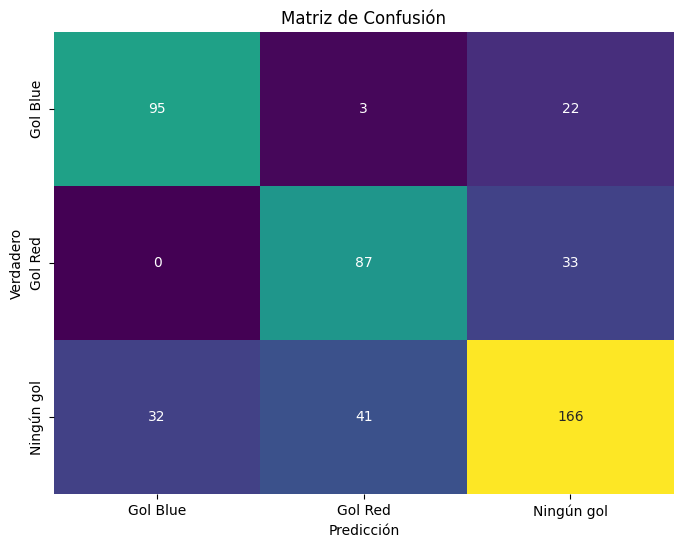

In [62]:
# Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = modelo.predict(X_test)
print(Counter(y_pred))
print(classification_report(y_test, y_pred, target_names=['Gol Blue', 'Gol Red', 'Ningún gol']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'],
            yticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [95]:
# Obtener las probabilidades de las predicciones en el conjunto de prueba
probabilidades = modelo.predict_proba(X_test)

# Convertir las probabilidades a un DataFrame
probabilidades_df = pd.DataFrame(probabilidades, columns=['%Blue', '%Red', '%None'])
probabilidades_df = probabilidades_df.round(5)

# Agregar las columnas de valor real
probabilidades_df['Valor real'] = y_test

# Reorganizar las columnas
probabilidades_df = probabilidades_df[['Valor real', '%Blue', '%Red', '%None']]

# Mostrar todas las filas (en Jupyter Notebook, muestra todas)
pd.set_option('display.max_rows', None)
print(probabilidades_df)

    Valor real    %Blue     %Red    %None
0         none  0.00037  0.00867  0.99096
1         none  0.00408  0.00000  0.99592
2          Red  0.00000  0.56791  0.43209
3         Blue  0.34071  0.00001  0.65929
4         Blue  0.99997  0.00000  0.00003
5         none  0.00000  0.00000  1.00000
6         none  0.00381  0.00015  0.99604
7         none  0.00002  0.00000  0.99998
8          Red  0.00000  0.95733  0.04267
9         none  0.71560  0.00002  0.28438
10        none  0.38160  0.00000  0.61840
11        none  0.01149  0.00001  0.98851
12        Blue  0.91777  0.02402  0.05821
13         Red  0.00009  0.67235  0.32756
14        Blue  0.01455  0.00491  0.98053
15         Red  0.00000  0.96244  0.03756
16        Blue  0.99573  0.00000  0.00427
17        none  0.99706  0.00000  0.00294
18        none  0.00663  0.95145  0.04192
19        Blue  0.82176  0.00049  0.17775
20         Red  0.00000  0.97609  0.02391
21        none  0.00122  0.00000  0.99878
22         Red  0.00000  0.97784  

In [114]:
probabilidades_df_sample_15 = probabilidades_df.sample(10, random_state=random_state).reset_index()
print(probabilidades_df_sample_15)

   index Valor real    %Blue     %Red    %None
0    471       none  0.00000  0.00024  0.99975
1    293       none  0.00000  0.00075  0.99924
2    339       Blue  0.01352  0.00022  0.98626
3    437        Red  0.00000  0.08641  0.91359
4    421       none  0.00003  0.02164  0.97833
5    227       none  0.09653  0.00027  0.90320
6    239       none  0.65892  0.00003  0.34105
7     63       Blue  0.83177  0.00000  0.16822
8    229       Blue  0.61015  0.00000  0.38985
9    341        Red  0.01002  0.07860  0.91138


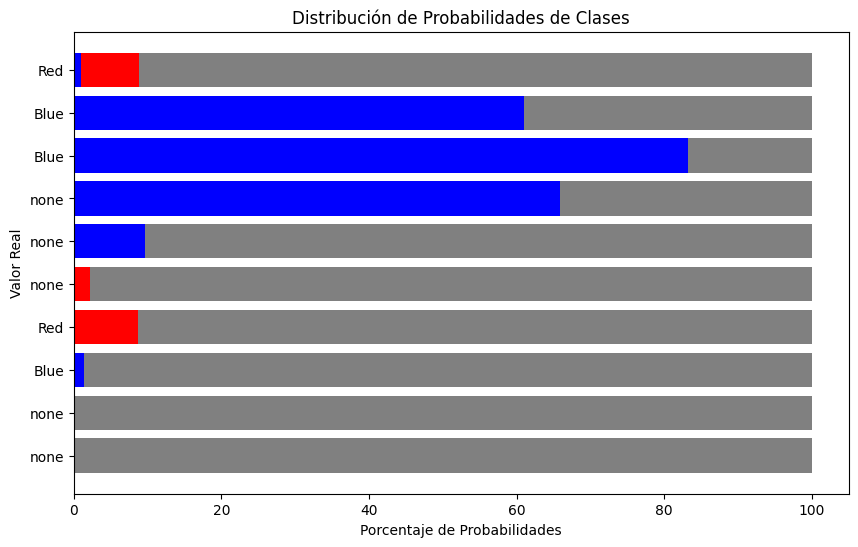

In [115]:
# Crear gráfico de barras apiladas horizontal
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras apiladas para cada fila
for i, row in probabilidades_df_sample_15.iterrows():
    ax.barh(i, row['%Blue']*100, color='blue')
    ax.barh(i, row['%Red']*100, left=row['%Blue']*100, color='red')
    ax.barh(i, row['%None']*100, left=(row['%Blue'] + row['%Red'])*100, color='gray')

# Etiquetas y título
ax.set_xlabel('Porcentaje de Probabilidades')
ax.set_ylabel('Valor Real')
ax.set_title('Distribución de Probabilidades de Clases')



# Asignar las etiquetas del eje Y con los valores de la columna 'Valor real'
ax.set_yticks(range(len(probabilidades_df_sample_15)))
ax.set_yticklabels(probabilidades_df_sample_15['Valor real'].values)

# Mostrar el gráfico
plt.show()

##### GridSearchCV + Cross Validation (Chequear)

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Ejecutar la validación cruzada con 5 pliegues
scores = cross_val_score(modelo, X, y, cv=5)

# Mostrar las puntuaciones para cada pliegue
print("Puntuaciones por pliegue:", scores)

# Promedio de las puntuaciones
print("Puntuación media de la validación cruzada:", scores.mean())

Puntuaciones por pliegue: [0.74375    0.73040752 0.68652038 0.7492163  0.70532915]
Puntuación media de la validación cruzada: 0.723044670846395


In [58]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a probar
param_grid = {
    'hidden_layer_sizes': [(128, 64, 32), (64, 32), (128, 128), (256, 128, 64)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01]
}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(MLPClassifier(max_iter=500, random_state=49287), param_grid, cv=5)

# Ajustar el modelo con los datos
grid_search.fit(X, y)

# Ver los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Ver la mejor puntuación obtenida
print("Mejor puntuación:", grid_search.best_score_)

C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

Mejores parámetros: {'alpha': 0.001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.001}
Mejor puntuación: 0.723044670846395


In [59]:
# Hacer predicciones con el mejor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluar el modelo con el conjunto de prueba
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Reporte de clasificación:
               precision    recall  f1-score   support

        Blue       0.99      1.00      1.00       120
         Red       0.98      1.00      0.99       120
        none       1.00      0.99      0.99       239

    accuracy                           0.99       479
   macro avg       0.99      1.00      0.99       479
weighted avg       0.99      0.99      0.99       479



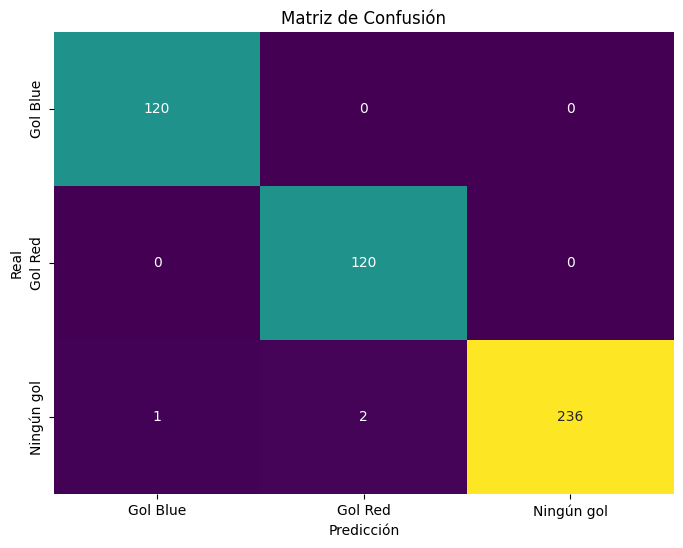

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'],
            yticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

#### No funciona:

In [47]:
#NO FUNCIONA ESTO

import pydot_ng as pydot

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

# Crear el modelo con Keras
model_keras = Sequential()
model_keras.add(Dense(128, input_dim=4, activation='relu'))
model_keras.add(Dense(64, activation='relu'))
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(3, activation='softmax'))  # Tres clases de salida (para el Iris dataset)

# Compilar el modelo
model_keras.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualizar la arquitectura
plot_model(model_keras, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Mostrar el gráfico
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')
plt.show()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model_architecture.png'

In [63]:
def get_features_for_match_time(match_id, time, data_pos):
    subset = data_pos[(data_pos['match_id'] == match_id) & (data_pos['time'] == time)]
    red_players = subset[subset['team'] == -1][['x', 'y', 'velocity_x', 'velocity_y']].values
    blue_players = subset[subset['team'] == 1][['x', 'y', 'velocity_x', 'velocity_y']].values
    ball = subset[subset['player_id'] == 0][['x', 'y', 'velocity_x', 'velocity_y']].values  # Suponer que la pelota tiene un id específico
    # Ordenar aleatoriamente para asegurar independencia del orden de jugadores
    np.random.shuffle(red_players)
    np.random.shuffle(blue_players)
    return np.concatenate([red_players.flatten(), blue_players.flatten(), ball.flatten()])

In [20]:
# Combinar los IDs para facilitar la búsqueda
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)


In [21]:
# Crear una lista de arrays con las posiciones y velocidades para cada match_time
X = []
y = []

print(data_posiciones_grouped_filtered_labeled)

for row in data_posiciones_grouped_filtered_labeled.itertuples():
    match_time = row.match_time
    gol_3_ticks = row.gol_3_ticks  # Etiqueta objetivo
    
    # Selecciona las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
    
    X.append(input_data)
    y.append(gol_3_ticks)

X = np.array(X)
y = np.array(y)


      match_id        time  entities gol_1_ticks gol_2_ticks gol_3_ticks  \
0           42    0.616667         7        none        none        none   
1           42    1.616667         7        none        none        none   
2           42    2.616667         7        none        none        none   
3           42    3.616667         7        none        none        none   
4           42    4.616667         7        none        none        none   
...        ...         ...       ...         ...         ...         ...   
9568       146  175.266667         7        none        none        none   
9569       146  176.266667         7        none        none        none   
9570       146  177.266667         7        none        none        Blue   
9571       146  178.266667         7        none        Blue        Blue   
9572       146  179.266667         7        Blue        Blue        Blue   

     gol_4_ticks gol_5_ticks gol_6_ticks              match_time  
0           none    

In [22]:
print(X_train[0])
#print(y)

[ 0.68778185  0.69470027  0.21491689  0.62581805 -1.          0.81712133
  0.16795554  0.19842362  0.64827061 -1.          0.50789688  0.16299576
  0.18772178  0.62840894 -1.          0.64900281  0.29557116  0.21264755
  0.64514266  1.          0.81149586  0.22524492  0.2136232   0.6350499
  1.          0.56489637  0.90262846  0.18510477  0.63814377  1.
  0.87593603  0.31332302  0.21574939  0.71379317  0.        ]


In [23]:
# Separo las clases
indices_nada = np.where(y == 'none')[0]  # Clase 'sin gol'
indices_gol_rojo = np.where(y == 'Red')[0]  # Clase 'gol del Red'
indices_gol_azul = np.where(y == 'Blue')[0]  # Clase 'gol del Blue'

#print(indices_nada)
#print(indices_gol_rojo)
#print(indices_gol_azul)

# Balanceo las clases y muestreo
from sklearn.utils import resample

# Proporcion 50% nada, 25% gol del Red, 25% gol del Blue
num_muestras_gol = round(min(len(indices_gol_rojo), len(indices_gol_azul))/5)
num_muestras_nada = num_muestras_gol * 2

indices_nada_balanceados = resample(indices_nada, replace=False, n_samples=num_muestras_nada, random_state=8493278)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, replace=False, n_samples=num_muestras_gol, random_state=8493278)
indices_gol_azul_balanceados = resample(indices_gol_azul, replace=False, n_samples=num_muestras_gol, random_state=8493278)

indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])

from sklearn.utils import shuffle
X_balanceado = X[indices_balanceados]
y_balanceado = y[indices_balanceados]
X_balanceado, y_balanceado = shuffle(X_balanceado, y_balanceado, random_state=8493278)

In [24]:
print(X_balanceado)
print(y_balanceado)

[[0.79615497 0.37683523 0.16981827 ... 0.15569417 0.57365649 0.        ]
 [0.38123957 0.810972   0.16683883 ... 0.13064919 0.55961371 0.        ]
 [0.7892562  0.5        0.18399394 ... 0.2275696  0.61158483 0.        ]
 ...
 [0.49806073 0.34934975 0.15844488 ... 0.15438007 0.63037845 0.        ]
 [0.65206746 0.64518467 0.18328442 ... 0.21184212 0.56064402 0.        ]
 [0.65690229 0.55287765 0.18426826 ... 0.20000286 0.70242323 0.        ]]
['none' 'none' 'none' 'none' 'none' 'Red' 'Blue' 'Blue' 'none' 'none'
 'none' 'Red' 'Red' 'Blue' 'none' 'Blue' 'Red' 'Blue' 'none' 'Red' 'Red'
 'Blue' 'none' 'none' 'Blue' 'none' 'Blue' 'none' 'none' 'none' 'Red'
 'none' 'none' 'none' 'Blue' 'Blue' 'none' 'none' 'none' 'none' 'none'
 'Red' 'none' 'none' 'Blue' 'none' 'Red' 'Red' 'Red' 'Red' 'Red' 'none'
 'Red' 'Red' 'none' 'Blue' 'Blue' 'none' 'Red' 'none' 'none' 'Blue' 'none'
 'Blue' 'Blue' 'Blue' 'Blue' 'Red' 'Red' 'Blue' 'Blue' 'none' 'none'
 'none' 'Red' 'Red' 'Blue' 'none' 'none' 'Blue' 'Blue' '

In [25]:
from collections import Counter
print(Counter(y_balanceado))

Counter({'none': 120, 'Red': 60, 'Blue': 60})


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado, test_size=0.3, random_state=8493278)

# Crear el modelo
modelo = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500)

# Entrenar el modelo
modelo.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500)

In [143]:
print(X_train[0])
print(y)

[ 0.3564175   0.22868618  0.20156429  0.6339028  -1.          0.38317639
  0.70794376  0.19684944  0.62752368 -1.          0.1161021   0.41668384
  0.18164728  0.65233634 -1.          0.34385163  0.30212629  0.18494632
  0.69794176  1.          0.5925615   0.48505096  0.20144511  0.6972939
  1.          0.54361929  0.51320129  0.18468838  0.62766902  1.
  0.27126723  0.07620462  0.17155718  0.58264536  0.        ]
['none' 'none' 'none' ... 'Blue' 'Blue' 'Blue']


In [133]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

  Ningún gol       0.67      0.63      0.65        19
    Gol rojo       0.44      0.44      0.44        18
    Gol azul       0.53      0.54      0.54        35

    accuracy                           0.54        72
   macro avg       0.55      0.54      0.54        72
weighted avg       0.54      0.54      0.54        72

[[12  0  7]
 [ 0  8 10]
 [ 6 10 19]]


              precision    recall  f1-score   support

  Ningún gol       0.47      0.88      0.61         8
    Gol rojo       0.50      0.75      0.60         8
    Gol azul       0.67      0.30      0.41        20

    accuracy                           0.53        36
   macro avg       0.54      0.64      0.54        36
weighted avg       0.59      0.53      0.50        36



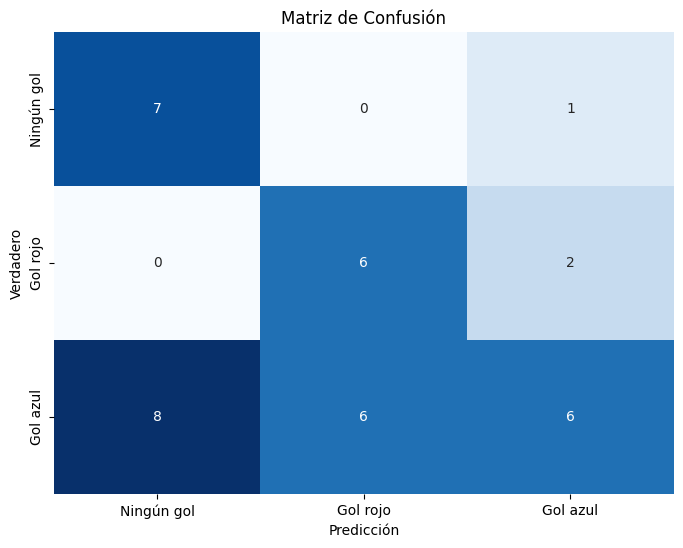


Explicación de la matriz de confusión:
Fila 0: Ningún gol (Verdadero)
 - Columna 0: Predicho como Ningún gol
 - Columna 1: Predicho como Gol rojo
 - Columna 2: Predicho como Gol azul
Fila 1: Gol rojo (Verdadero)
 - Columna 0: Predicho como Ningún gol
 - Columna 1: Predicho como Gol rojo
 - Columna 2: Predicho como Gol azul
Fila 2: Gol azul (Verdadero)
 - Columna 0: Predicho como Ningún gol
 - Columna 1: Predicho como Gol rojo
 - Columna 2: Predicho como Gol azul


In [101]:
# Predicciones
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'],
            yticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Explicación de la matriz
tabla_explicacion = {
    'Filas (Verdadero)': ['Ningún gol', 'Gol rojo', 'Gol azul'],
    'Columnas (Predicción)': ['Ningún gol', 'Gol rojo', 'Gol azul']
}
print("\nExplicación de la matriz de confusión:")
for i, fila in enumerate(tabla_explicacion['Filas (Verdadero)']):
    print(f"Fila {i}: {fila} (Verdadero)")
    print(f" - Columna 0: Predicho como {tabla_explicacion['Columnas (Predicción)'][0]}")
    print(f" - Columna 1: Predicho como {tabla_explicacion['Columnas (Predicción)'][1]}")
    print(f" - Columna 2: Predicho como {tabla_explicacion['Columnas (Predicción)'][2]}")

In [63]:
ejemplo_crudo_test1 = [
-92.56451288707532,	124.45015137068071,	159.4897871523994,	12.686438615544656,	1,
-46.86904236747758,	-82.09417184724326,	162.2066739689642,	3.8808615266944106,	1,
-1.0282322976049685,	-158.42819156230084,138.42971007348893,	20.278973949055498,	1,
-15.400174216859035,	-132.0779034978056,	106.8216737279782,	-14.19809709458249,	2,
369.8938602877177,	-34.44229930738148, 112.5701383585176,	-0.46031655316848,	2,
14.03888309503283,	-126.30365856126663, 123.08482179344048,	-36.63696694933308,	1,
33.03107592831144,	-135.74791243559724,	92.00083312965478,	68.79246629432616,	0
]

columns = ['x', 'y', 'velocity_x', 'velocity_y', 'team']
data_test1 = pd.DataFrame([ejemplo_crudo_test1[i:i + 5] for i in range(0, len(ejemplo_crudo_test1), 5)], columns=columns)

data_test1_normalizada = normalizar_datos(data_test1)
print(data_test1_normalizada)

          x         y  velocity_x  velocity_y  team
0  0.000000  1.000000    0.961301    0.467833    -1
1  0.098810  0.269848    1.000000    0.384312    -1
2  0.197934  0.000000    0.661325    0.539849    -1
3  0.166857  0.093151    0.211106    0.212833     1
4  1.000000  0.438301    0.292986    0.343136     1
5  0.230515  0.113563    0.442755    0.000000    -1
6  0.271582  0.080177    0.000000    1.000000     0


### ...etc... (no correr)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definir el modelo
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Salida para 3 clases: ninguno, gol rojo, gol azul
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Entrenar el modelo
history = model.fit(X, y.argmax(axis=1), epochs=50, batch_size=32, validation_split=0.2)


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
loss, accuracy = model.evaluate(X, y.argmax(axis=1))
print(f"Loss: {loss}, Accuracy: {accuracy}")


In [ ]:
# Predecir probabilidades para cada entrada
predicciones_probabilidades = model.predict(X)

# Convertir las probabilidades en clases (0, 1, 2)
predicciones_clases = predicciones_probabilidades.argmax(axis=1)


In [ ]:
import pandas as pd

# Crear un DataFrame para analizar
resultados = pd.DataFrame({
    'match_id': data_posiciones_grouped_filtered_labeled['match_id'],
    'time': data_posiciones_grouped_filtered_labeled['time'],
    'prediccion_clase': predicciones_clases,
    'gol_verdadero': y.argmax(axis=1),  # Convertir las etiquetas verdaderas en la misma forma
    'prob_nada': predicciones_probabilidades[:, 0],
    'prob_gol_rojo': predicciones_probabilidades[:, 1],
    'prob_gol_azul': predicciones_probabilidades[:, 2],
})

# Mostrar los primeros resultados
print(resultados.sample(10))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar un informe de clasificación
print(classification_report(y.argmax(axis=1), predicciones_clases, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
print(confusion_matrix(y.argmax(axis=1), predicciones_clases))
